### Δεδομένα

Data Link: https://www.cryptodatadownload.com/data/binance/ 

Τα δεδομένα που χρησιμοποιούμε είναι από την πλατφόρμα της binance.

### Λίγες πληρφορίες για αυτά:

Περιέχουν τις πληροφορίες του bitcoin ανά λεπτό.


Επίσης η πληροφορία που μας ενδιαφέρει είναι το close του BTC. Το close είναι η τιμή που διαμορφόθηκε εκείνη τη στιγμή στο bitcoin. Το volume είναι η ποσότητα που αγοράστηκε/πουλήθηκε εκείνη τι στιγμή. 

'Αρα στην ουσία το close είναι η τιμή ενός BTC που συναλλάχθηκε εκέίνη τη στιγμή και το volume είναι η ποσότητα που συναλλάχθηκε.

Το open είναι η τιμή που άνοιξε στο bitcoin, το low είναι η χαμηλότερη τιμή πώλησης του ανοίγματος και το high η ηψυλότερη τιμή

# Εισάγουμε τις βιβλίοθηκες

In [34]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score
from sklearn.preprocessing import MinMaxScaler
import random
import time
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
%matplotlib inline

In [35]:
# φορτώνουμε τα δεδομένα μας, στη συγκεκριμένη περίπτωση, διαβάζουμε τις πρώτες 10Κ γραμμές
# διότι διαφορετικά αργεί την όλη διαδικασία, ταυτόχρονα διαγράφουμε τις γραμμές που
# έχουν έστω μια null τιμή
btc_input_df  = pd.read_csv("btc_Oct_2015_to_Oct_2021.csv", parse_dates=["time"], nrows=1440)
btc_input_df.head()

,time,low,high,open,close,volume
0,2021-10-30 03:00:00,61868.81,61920.00,61888.18,61919.98,2.946079
1,2021-10-30 02:59:00,61882.74,61912.67,61903.16,61882.74,2.942357
2,2021-10-30 02:58:00,61854.82,61907.96,61854.82,61903.15,3.047848
3,2021-10-30 02:57:00,61848.04,61883.02,61883.01,61851.39,3.381070
4,2021-10-30 02:56:00,61879.33,61925.42,61907.47,61882.28,5.663128


In [36]:
# btc_input_df.sort_values(by=['time'], inplace=True)
btc_input_df = btc_input_df.set_index('time')
btc_input_df.head()

,low,high,open,close,volume
time,,,,,
2021-10-30 03:00:00,61868.81,61920.00,61888.18,61919.98,2.946079
2021-10-30 02:59:00,61882.74,61912.67,61903.16,61882.74,2.942357
2021-10-30 02:58:00,61854.82,61907.96,61854.82,61903.15,3.047848
2021-10-30 02:57:00,61848.04,61883.02,61883.01,61851.39,3.381070
2021-10-30 02:56:00,61879.33,61925.42,61907.47,61882.28,5.663128


In [37]:
print(btc_input_df.shape)
print("------------------------")
print(btc_input_df.info())

(1440, 5)
------------------------
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1440 entries, 2021-10-30 03:00:00 to 2021-10-29 03:01:00
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   low     1440 non-null   float64
 1   high    1440 non-null   float64
 2   open    1440 non-null   float64
 3   close   1440 non-null   float64
 4   volume  1440 non-null   float64
dtypes: float64(5)
memory usage: 67.5 KB
None


In [39]:
print('Null Values:',btc_input_df.isnull().values.sum())
print('If any NA values:', btc_input_df.isnull().values.any())

Null Values: 0
If any NA values: False


In [40]:
btc_input_df.head()

,low,high,open,close,volume
time,,,,,
2021-10-30 03:00:00,61868.81,61920.00,61888.18,61919.98,2.946079
2021-10-30 02:59:00,61882.74,61912.67,61903.16,61882.74,2.942357
2021-10-30 02:58:00,61854.82,61907.96,61854.82,61903.15,3.047848
2021-10-30 02:57:00,61848.04,61883.02,61883.01,61851.39,3.381070
2021-10-30 02:56:00,61879.33,61925.42,61907.47,61882.28,5.663128


In [41]:
btc_input_df.tail()

,low,high,open,close,volume
time,,,,,
2021-10-29 03:05:00,61601.65,61699.11,61601.69,61693.13,6.331365
2021-10-29 03:04:00,61546.11,61604.47,61596.47,61604.47,6.702590
2021-10-29 03:03:00,61593.32,61611.45,61605.16,61596.48,2.279936
2021-10-29 03:02:00,61603.45,61665.50,61665.24,61606.40,1.898041
2021-10-29 03:01:00,61649.50,61681.09,61649.50,61665.24,2.201539


<AxesSubplot:title={'center':'Bitcoin Price'}, xlabel='time'>

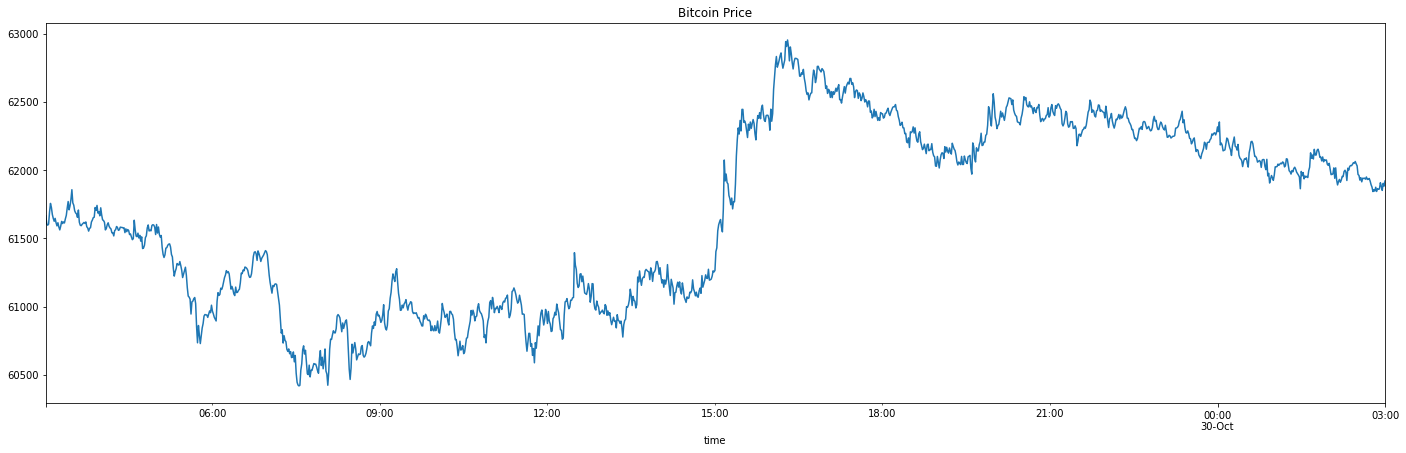

In [43]:
btc_input_df.close.plot(figsize=(24,7), title="Bitcoin Price")

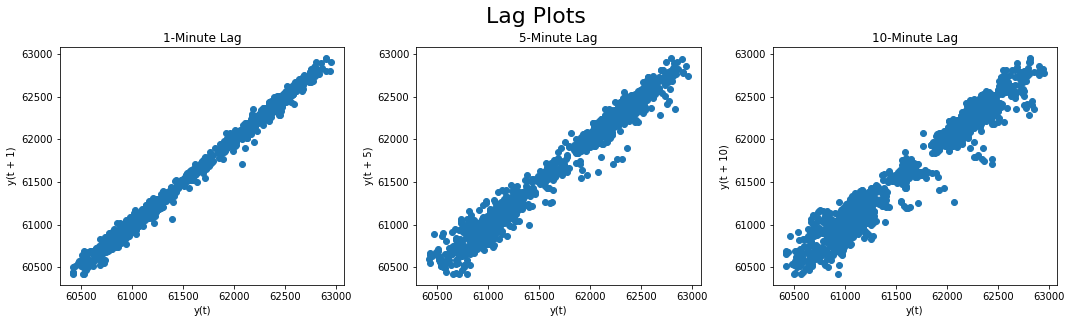

In [45]:
# κάνουμε plot το corelation 
plt.figure(figsize=(15,12))
plt.suptitle('Lag Plots', fontsize=22)

plt.subplot(3,3,1)
pd.plotting.lag_plot(btc_input_df['close'], lag=1) #minute lag
plt.title('1-Minute Lag')

plt.subplot(3,3,2)
pd.plotting.lag_plot(btc_input_df['close'], lag=5) 
plt.title('5-Minute Lag')

plt.subplot(3,3,3)
pd.plotting.lag_plot(btc_input_df['close'], lag=10) 
plt.title('10-Minute Lag')

plt.tight_layout()

In [46]:
btc_closing_price = btc_input_df['close']
btc_closing_price.head()

time
2021-10-30 03:00:00    61919.98
2021-10-30 02:59:00    61882.74
2021-10-30 02:58:00    61903.15
2021-10-30 02:57:00    61851.39
2021-10-30 02:56:00    61882.28
Name: close, dtype: float64

In [47]:
type(btc_closing_price)

pandas.core.series.Series

In [49]:
df_train= btc_closing_price[200:]
df_test= btc_closing_price[:200]

In [50]:
df_test.shape

(200,)

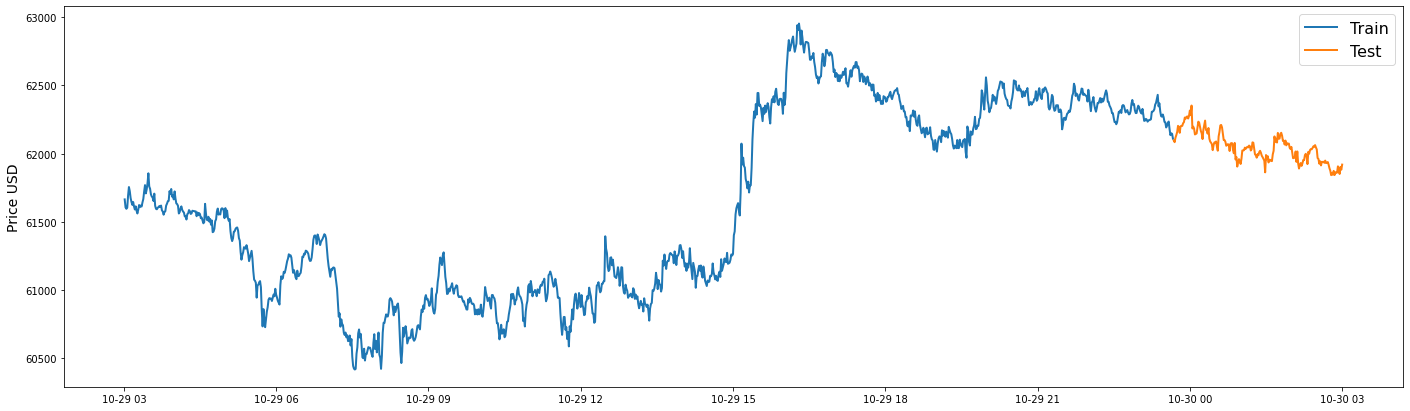

In [51]:
fig, ax = plt.subplots(1, figsize=(24, 7))
ax.plot(df_train, label='Train', linewidth=2)
ax.plot(df_test, label='Test', linewidth=2)
ax.set_ylabel('Price USD', fontsize=14)
ax.set_title('', fontsize=16)
ax.legend(loc='best', fontsize=16)

In [52]:
df_train= df_train.values.reshape(-1,1)
df_test= df_test.values.reshape(-1,1)

In [53]:
"""
Ο λόγος που χωρίζουμε πρώτα τα δεδομένα μας και μετά τα κανονικοποιούμε
είναι διότι αν κάναμε το αντίθετο, όταν θα γινόταν το scaling, θα χρησιμοποιούνταν
(ως σημείο αναφοράς) τα δεδομένα που έχουμε ως training και αυτό θα επηρέαζε τα δεδομένα εκαπίδευσης.
Στην ουσία θα είχαμ "διαρροή" των αποτελεσμάτων του training set
"""

scaler_train = MinMaxScaler(feature_range=(0, 1))
scaled_train = scaler_train.fit_transform(df_train)

scaler_test = MinMaxScaler(feature_range=(0, 1))
scaled_test = scaler_test.fit_transform(df_test)

In [54]:
"""
Θα δημιουργήσουμε μια συνάρτηση που θα χωρίζει το datest σε input που θα δέχεται
το μοντέλο και τα label που πρέπει να προβλέπει.

Για παράδειγμα αν τα δεδομένα μας είχαν την μορφή [1, 2, 3, 4, 5, 6]
τότε τα input που θα παίρνει το μοντέλο μας και το αντίστοιχο output , θα ήταν κάπως έτσι:

Input | Output
1, 2      3
2, 3      4
3, 4      5
4, 5      6


Τα LSTMs δέχονται σαν είσοδο δεδομένα 2 διαστάσεων.
Η πρώτη διάσταση είναι ο αριθμός των χρονικών βημάτων, στο παράδειγμα μας είναι 2,
και η δεύτερη διάσταση είναι ο αριθμός των παρατηρήσεων ανά χρονικό βήμα, στο παράδειγμα είναι 1

"""
def dataset_generator_lstm(dataset, look_back=10):
    """
    Συνάρτηση που επιστρέφει όσα περιγράψαμε παραπάνω. Η παράμετρος
    look back προσδιορίζει πόσα προηγούμενα timesteps θα λάβουμε υπόψη
    για να προβλέψουμε το επόμενο timestep.
    Για παράδειγμα αν θέλουμε να προβλέψουμε τι θα γίνει την χρονική στιγμή t+1 (όπου t είναι η τωρινη
    χρονική στιγμή.) με look back ίσο με 10 , τότε θα χρησιμοποιουθούν τα δεδομένα της χρονική στιγμής
    t-9 , t-8, ... , t-1, t-0
    """    
    dataX, dataY = [], []
    
    for i in range(len(dataset) - look_back):
        
        window_size_x = dataset[i:(i + look_back), 0]
        dataX.append(window_size_x)
        dataY.append(dataset[i + look_back, 0])
        
    return np.array(dataX), np.array(dataY)


trainX, trainY = dataset_generator_lstm(scaled_train)
testX, testY = dataset_generator_lstm(scaled_test)

print("trainX: ", trainX.shape)
print("trainY: ", trainY.shape)
print("testΧ: ", testX.shape)
print("testY", testY.shape)

trainX:  (1230, 10)
trainY:  (1230,)
testΧ:  (190, 10)
testY (190,)


Για το LSTM πρέπει να αναδιαμορφώσoyme την είσοδο ώστε να είναι ένας τρισδιάστατος πίνακας 
[δείγματα , χρονικά βήματα, χαρακτηριστικά]

Δείγματα (Samples): Είναι το len(trainX) , δηλαδή η ποσότητα των data points που έχουμε

Χαρακτηριστικά (Features): Η ποσότητα των χαρακτηριστικών σε κάθε timestep. Στην συγκεκριμένη περίπτωση το χαρακτηριστικό που έχουμε είναι η τιμή του bitcoin. 

Σημείωση: Σύμφωνα με το documentation του keras, το input πρέπει να είναι της μορφής 
[batch_size, timesteps, input_dim]. Ο αριθμός των timesteps είανι ίσος με τον αριθμό των LSTM cells. 

In [55]:
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))

testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1 ))

print("Shape of trainX: ", trainX.shape)
print("Shape of testX: ", testX.shape)

Shape of trainX:  (1230, 10, 1)
Shape of testX:  (190, 10, 1)


In [56]:
print("trainX.shape[1] - i.e. timesteps in input_shape = (timesteps, n_features) ", trainX.shape[1])
print("trainX.shape[2] - i.e. n_features in input_shape = (timesteps, n_features) ", trainX.shape[2])

trainX.shape[1] - i.e. timesteps in input_shape = (timesteps, n_features)  10
trainX.shape[2] - i.e. n_features in input_shape = (timesteps, n_features)  1


In [57]:
model = Sequential()

# model.add(LSTM(units = 32, activation = 'relu', return_sequences=True, input_shape = (trainX.shape[1], trainX.shape[2])))
# model.add(Dropout(0.2))

model.add(LSTM(units = 64, activation = 'relu', return_sequences=False, input_shape = (trainX.shape[1], trainX.shape[2])))
model.add(Dropout(0.2))

# model.add(LSTM(units = 64, activation = 'relu', return_sequences=True, input_shape = (trainX.shape[1], trainX.shape[2])))
# model.add(Dropout(0.2))

# model.add(LSTM(units = 64, activation = 'relu', return_sequences=True, input_shape = (trainX.shape[1], trainX.shape[2])))
# model.add(Dropout(0.2))

# model.add(LSTM(units = 64, input_shape = (trainX.shape[1], trainX.shape[2])))
# model.add(Dropout(0.2))

model.add(Dense(units = 1))

In [58]:
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

checkpoint_path = f'./models/best_model_{int(time.time())}.hdf5'

checkpoint = ModelCheckpoint(filepath=checkpoint_path, 
                             monitor='val_loss',
                             verbose=1, 
                             save_best_only=True,
                             mode='min')


earlystopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

callbacks = [checkpoint, earlystopping]


history = model.fit(trainX, trainY, batch_size = 64, epochs = 100, verbose=1, shuffle=False, validation_split=0.2, callbacks=callbacks)

Epoch 1/100
15/16 [===========================>..] - ETA: 0s - loss: 0.3208
Epoch 00001: val_loss improved from inf to 0.07876, saving model to ./models\best_model_1646434549.hdf5
16/16 [==============================] - 3s 54ms/step - loss: 0.3133 - val_loss: 0.0788
Epoch 2/100
16/16 [==============================] - ETA: 0s - loss: 0.1580
Epoch 00002: val_loss improved from 0.07876 to 0.02046, saving model to ./models\best_model_1646434549.hdf5
16/16 [==============================] - 0s 29ms/step - loss: 0.1580 - val_loss: 0.0205
Epoch 3/100
16/16 [==============================] - ETA: 0s - loss: 0.0505
Epoch 00003: val_loss improved from 0.02046 to 0.00656, saving model to ./models\best_model_1646434549.hdf5
16/16 [==============================] - 0s 23ms/step - loss: 0.0505 - val_loss: 0.0066
Epoch 4/100
13/16 [=======================>......] - ETA: 0s - loss: 0.0112
Epoch 00004: val_loss did not improve from 0.00656
16/16 [==============================] - 0s 19ms/step - loss:

In [59]:
model_from_saved_checkpoint = load_model(checkpoint_path)

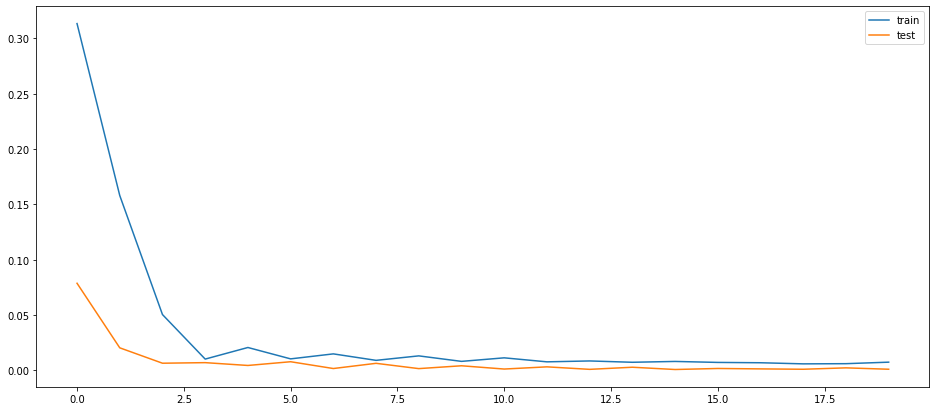

In [60]:
plt.figure(figsize=(16,7))
plt.plot(history.history['loss'], label='train')

plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [61]:
# Τα μετατρέπουμε στην κανονική τους μορφή και κάνουμε τις προβλέψεις

predicted_btc_price_test_data = model_from_saved_checkpoint.predict(testX)

predicted_btc_price_test_data = scaler_test.inverse_transform(predicted_btc_price_test_data.reshape(-1, 1))

test_actual = scaler_test.inverse_transform(testY.reshape(-1, 1))

def rmse(predictions, targets):
    return np.sqrt(np.mean((predictions-targets)**2))

print(f"Mean Absolute Error: {mean_absolute_error(predicted_btc_price_test_data, test_actual)}")
print(f"Mean Square Error: {mean_squared_error(predicted_btc_price_test_data, test_actual)}")
print(f"r2 score: {r2_score(predicted_btc_price_test_data, test_actual)}")
print(f"Root Mean Squar Error: {rmse(predicted_btc_price_test_data, test_actual)}")

Mean Absolute Error: 41.67159786184214
Mean Square Error: 2793.731329842843
r2 score: 0.7021318948398358
Root Mean Squar Error: 52.855759665743555


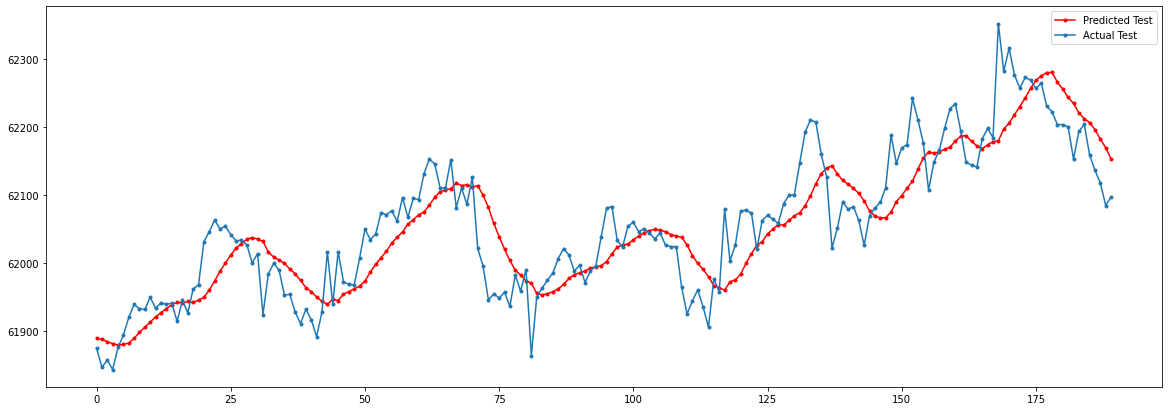

In [62]:
plt.figure(figsize=(20,7))

plt.plot(predicted_btc_price_test_data, 'r', marker='.', label='Predicted Test')

plt.plot(test_actual, marker='.', label='Actual Test')

plt.legend()
plt.show()

In [63]:
# Τα μετατρέπουμε στην κανονική τους μορφή και κάνουμε τις προβλέψεις

predicted_btc_price_train_data = model_from_saved_checkpoint.predict(trainX)

predicted_btc_price_train_data = scaler_train.inverse_transform(predicted_btc_price_train_data.reshape(-1, 1))

train_actual = scaler_train.inverse_transform(trainY.reshape(-1, 1))

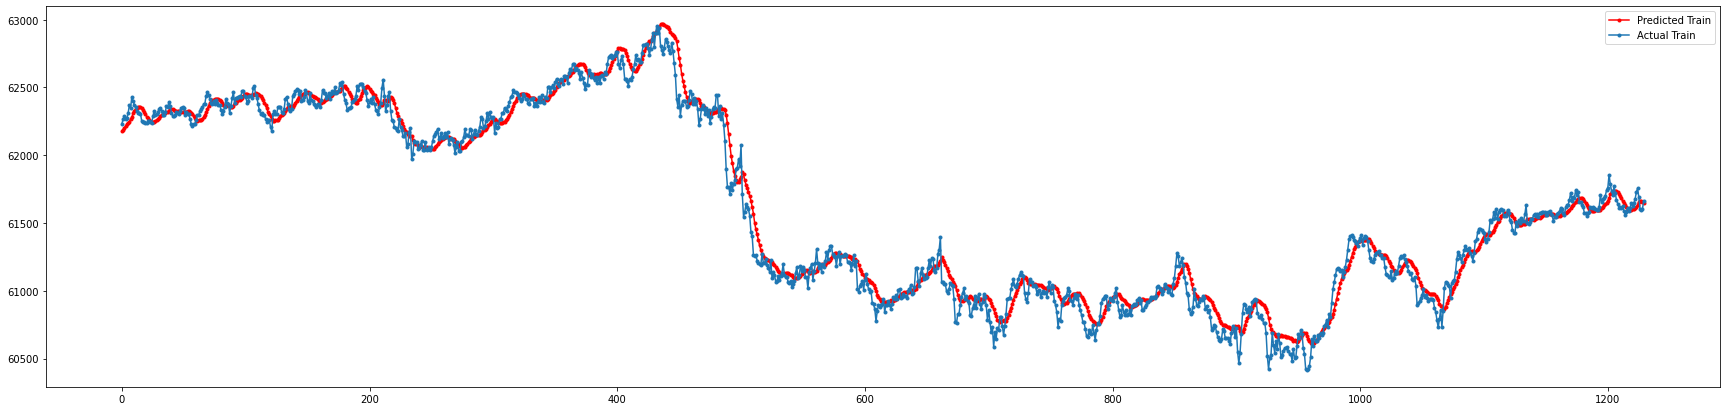

In [64]:
plt.figure(figsize=(30,7))

plt.plot(predicted_btc_price_train_data, 'r', marker='.', label='Predicted Train')

plt.plot(train_actual, marker='.', label='Actual Train')

plt.legend()
plt.show()

In [65]:
df_strategy_actual = pd.DataFrame(test_actual)
df_strategy_predicted = pd.DataFrame(predicted_btc_price_test_data)

df_strategy_actual = df_strategy_actual.rename(columns={0: "close"})
df_strategy_predicted = df_strategy_predicted.rename(columns={0: "close"})

In [66]:
df_strategy_actual.head()

,close
0,61874.24
1,61845.96
2,61856.69
3,61842.84
4,61875.53


In [67]:
df_strategy_predicted.head()

,close
0,61889.234375
1,61887.273438
2,61883.742188
3,61881.109375
4,61878.925781


In [68]:
def classify(current, future):
    if future is None:
        return
    """
    Επιστρέφει 1 αν η τιμή στο μέλλον είναι αυξημένη ή
    0 αν η τιμή στο μέλλον είναι μειωμένη
    """
    if float(future) > float(current):
        return 1
    else:
        return 0

In [69]:
df_strategy_actual['future'] = df_strategy_actual["close"].shift(-1)

df_strategy_predicted['future'] = df_strategy_predicted["close"].shift(-1)

df_strategy_actual['target'] = list(map(classify, df_strategy_actual["close"], df_strategy_actual["future"]))

df_strategy_predicted['target'] = list(map(classify, df_strategy_predicted["close"], df_strategy_predicted["future"]))

frames = [df_strategy_actual, df_strategy_predicted]

result = pd.concat(frames, axis=1, ignore_index=True)

result = result.rename(columns={0: "actual_close", 
                                1:"actual_future_close", 
                                2:"actual_target",
                                3:"predicted_close",
                                4:"predicted_future_close",
                                5:"predicted_target"})

result.head()

,actual_close,actual_future_close,actual_target,predicted_close,predicted_future_close,predicted_target
0,61874.24,61845.96,0,61889.234375,61887.273438,0
1,61845.96,61856.69,1,61887.273438,61883.742188,0
2,61856.69,61842.84,0,61883.742188,61881.109375,0
3,61842.84,61875.53,1,61881.109375,61878.925781,0
4,61875.53,61893.26,1,61878.925781,61879.710938,1


In [70]:
result.drop(['actual_future_close', 'predicted_future_close'], axis=1, inplace=True)
result.head()

,actual_close,actual_target,predicted_close,predicted_target
0,61874.24,0,61889.234375,0
1,61845.96,1,61887.273438,0
2,61856.69,0,61883.742188,0
3,61842.84,1,61881.109375,0
4,61875.53,1,61878.925781,1


In [71]:
result

,actual_close,actual_target,predicted_close,predicted_target
0,61874.24,0,61889.234375,0
1,61845.96,1,61887.273438,0
2,61856.69,0,61883.742188,0
3,61842.84,1,61881.109375,0
4,61875.53,1,61878.925781,1
...,...,...,...,...
185,62159.01,0,62206.703125,0
186,62136.38,0,62196.367188,0
187,62117.49,0,62182.503906,0
188,62084.41,1,62169.566406,0


In [135]:
# σε κάθε κίνηση θα ανταλλάσουμε το 5% του χαρτοφυλακίου μας
def trade(df, usd=100):
    cnt = 0
    my_actual_btc = 0
    percentage_buy = 0.1
    percentage_sell = 0.1
    profit = 0
    
    for index, target in enumerate(result['predicted_target']):
        # αν μας τελείωσαν όλα, τελειώνει ο αλγόριθμος
        if usd == 0 and btc == 0:
            return 0
        
        # αγοράζουμε
        if target == 1 and usd > 10:
            buy = percentage_buy * usd
            my_actual_btc = buy / df['actual_close'][index] + my_actual_btc
            usd = usd - buy
            print(f'{cnt} --------------------------------------------------------------------')
            print(f"You have spent {buy} dollars Total: {my_actual_btc} btc")
            print('-------------------------------------------------------------')
            cnt += 1


        # πουλάμε 
        if target == 0 and my_actual_btc > 0:
            sell = my_actual_btc * percentage_sell 
            usd = sell * df['actual_close'][index] + usd
            my_actual_btc = my_actual_btc - sell
            print(f'{cnt} --------------------------------------------------------------------')           
            print(f"Real: You get: {sell} usd Total: {usd} usd")
            print("--------------------------------------------")
            cnt += 1
    
    print("-------------- END ----------------")
    print(f"USD: {usd}, BTC:{my_actual_btc} Total -> {usd + df['actual_close'].values[-1] * my_actual_btc} usd")             
    return usd, my_actual_btc

In [136]:
usd, btc = trade(result)

0 --------------------------------------------------------------------
You have spent 10.0 dollars Total: 0.0001616147772794835 btc
-------------------------------------------------------------
1 --------------------------------------------------------------------
You have spent 9.0 dollars Total: 0.0003070264101454854 btc
-------------------------------------------------------------
2 --------------------------------------------------------------------
You have spent 8.1 dollars Total: 0.00043784120869069565 btc
-------------------------------------------------------------
3 --------------------------------------------------------------------
You have spent 7.290000000000001 dollars Total: 0.0005555380890129881 btc
-------------------------------------------------------------
4 --------------------------------------------------------------------
You have spent 6.561 dollars Total: 0.0006614760908197954 btc
-------------------------------------------------------------
5 ---------------

In [74]:
# για να προβλέψουμε την τιμή της επ΄όμενης μέρας που δεν έχουμε στα δεδομένα μας, θα πρέπει να
# περάσουμε στο μον΄τέλο μας τις look_back μέρες και θα πάρουμε σαν output την επόμενη μέρα
# Όμοια για να πάρουμε την επόμενη μέρα από την αυριανή μέρα, θα δώσουμε σαν input στο μοντέλο μας
# τα δεδομένα των lookback - 1 μερών για να πάρουμε σαν output την μεθαυριανή μέρα
lookback_period = 30
testX_last_days = testX[testX.shape[0] - lookback_period :  ]
testX_last_days.shape

(30, 10, 1)

In [75]:
predicted_days_forecast_price_test_x = []

for i in range(lookback_period):  
    predicted_forecast_price_test_x = model_from_saved_checkpoint.predict(testX_last_days[i:i+1])
  
    predicted_forecast_price_test_x = scaler_test.inverse_transform(predicted_forecast_price_test_x.reshape(-1, 1))
    predicted_days_forecast_price_test_x.append(predicted_forecast_price_test_x)


In [76]:
predicted_days_forecast_price_test_x = np.array(predicted_days_forecast_price_test_x)

predicted_days_forecast_price_test_x.shape

(30, 1, 1)

In [77]:
predicted_btc_price_test_data.shape

(190, 1)

In [78]:
predicted_days_forecast_price_test_x = predicted_days_forecast_price_test_x.flatten()

predicted_btc_price_test_data = predicted_btc_price_test_data.flatten()

In [79]:
predicted_btc_test_concatenated = np.concatenate((predicted_btc_price_test_data, predicted_days_forecast_price_test_x))

predicted_btc_test_concatenated.shape

(220,)

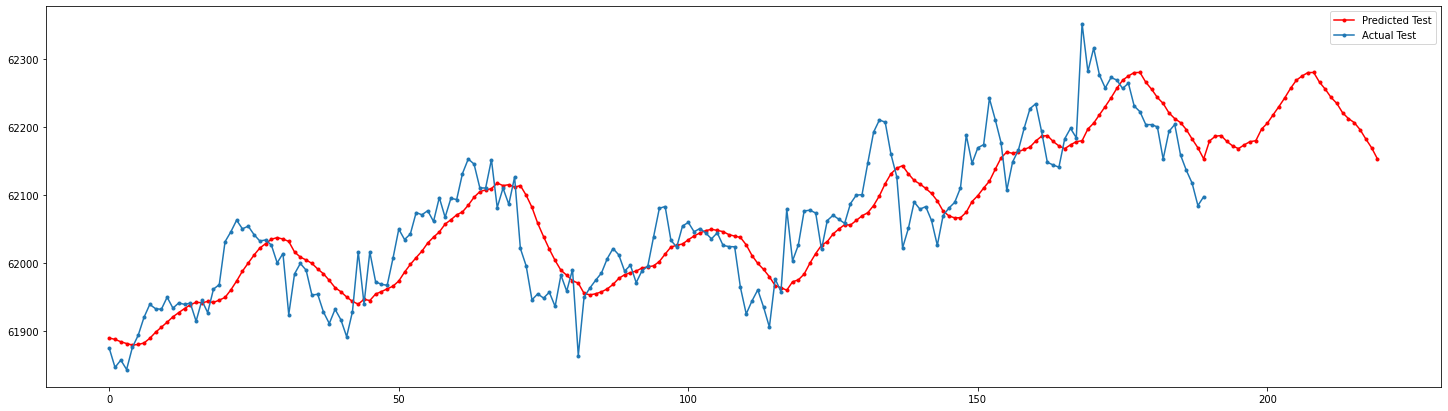

In [80]:
plt.figure(figsize=(25,7))

plt.plot(predicted_btc_test_concatenated, 'r', marker='.', label='Predicted Test')

plt.plot(test_actual, marker='.', label='Actual Test')

plt.legend()

plt.show()

In [81]:
def sharpe_ratio(rets):
    return rets.mean() / rets.std()

def positions(x, theta):
    """
    Επιστρέφει μια τιμή ανάμεσα στο -1 και 1. Η
    τιμή αυτή αντιπροσωπεύει το ποσοστό που πρέπει να πουλήοσυμε
    ή να αγοράσουμε από το διαθέσιμο χαρτοφυλάκιο μας.
    """
    M = len(theta) - 2
    T = len(x)
    Ft = np.zeros(T)
    for t in range(M, T):
        xt = np.concatenate([[1], x[t - M:t], [Ft[t - 1]]])
        Ft[t] = np.tanh(np.dot(theta, xt))
    return Ft

def returns(Ft, x, delta=0):
    T = len(x)
    rets = Ft[0:T - 1] * x[1:T] - delta * np.abs(Ft[1:T] - Ft[0:T - 1])
    return np.concatenate([[0], rets])

def gradient(x, theta, delta):
    Ft = positions(x, theta)
    R = returns(Ft, x, delta)
    T = len(x)
    M = len(theta) - 2
    
    A = np.mean(R)
    B = np.mean(np.square(R))
    S = A / np.sqrt(B - A ** 2)

    dSdA = S * (1 + S ** 2) / A
    dSdB = -S ** 3 / 2 / A ** 2
    dAdR = 1. / T
    dBdR = 2. / T * R
    
    grad = np.zeros(M + 2)  
    dFpdtheta = np.zeros(M + 2)  
    
    for t in range(M, T):
        xt = np.concatenate([[1], x[t - M:t], [Ft[t-1]]])
        dRdF = -delta * np.sign(Ft[t] - Ft[t-1])
        dRdFp = x[t] + delta * np.sign(Ft[t] - Ft[t-1])
        dFdtheta = (1 - Ft[t] ** 2) * (xt + theta[-1] * dFpdtheta)
        dSdtheta = (dSdA * dAdR + dSdB * dBdR[t]) * (dRdF * dFdtheta + dRdFp * dFpdtheta)
        grad = grad + dSdtheta
        dFpdtheta = dFdtheta

        
    return grad, S

def train(x, epochs=2000, M=8, commission=0.0025, learning_rate = 0.3):
    theta = np.random.rand(M + 2)
    sharpes = np.zeros(epochs) 
    for i in range(epochs):
        grad, sharpe = gradient(x, theta, commission)
        theta = theta + grad * learning_rate

        sharpes[i] = sharpe
    
    
    print("finished training")
    return theta, sharpes

In [122]:
%%time
rets = btc_input_df['close'].diff()[1:1000]

x = np.array(rets)

N = 900 
P = 100
x_train = x[-(N+P):-P]
x_test = x[-P:]

std = np.std(x_train)
mean = np.mean(x_train)

x_train = (x_train - mean) / std
x_test = (x_test - mean) / std

np.random.seed(0)
print('start training')
theta, sharpes = train(x_train, epochs=100, M=10, commission=0, learning_rate=0.3)

start training
finished training
CPU times: total: 5.94 s
Wall time: 5.93 s


In [123]:
rets.head()

time
2021-10-30 02:59:00   -37.24
2021-10-30 02:58:00    20.41
2021-10-30 02:57:00   -51.76
2021-10-30 02:56:00    30.89
2021-10-30 02:55:00    25.20
Name: close, dtype: float64

Text(0, 0.5, 'Sharpe Ratio')

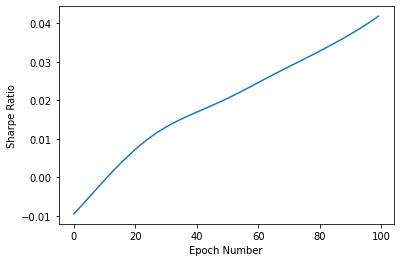

In [124]:
plt.plot(sharpes)
plt.xlabel('Epoch Number')
plt.ylabel('Sharpe Ratio')

In [125]:
test_returns = returns(positions(x_test, theta), x_test, 0.0025)

print(f"Mean Absolute Error: {mean_absolute_error(x_test.cumsum(), test_returns.cumsum())}")
print(f"Mean Squared Error: {mean_squared_error(x_test.cumsum(), test_returns.cumsum())}")
print(f"r2 score: {r2_score(x_test.cumsum(), test_returns.cumsum())}")
print(f"Root Mean Square Error: {rmse(x_test.cumsum(), test_returns.cumsum())}")

Mean Absolute Error: 3.275388958932242
Mean Squared Error: 16.292080301299055
r2 score: -1.2654543873533934
Root Mean Square Error: 4.036344918524562


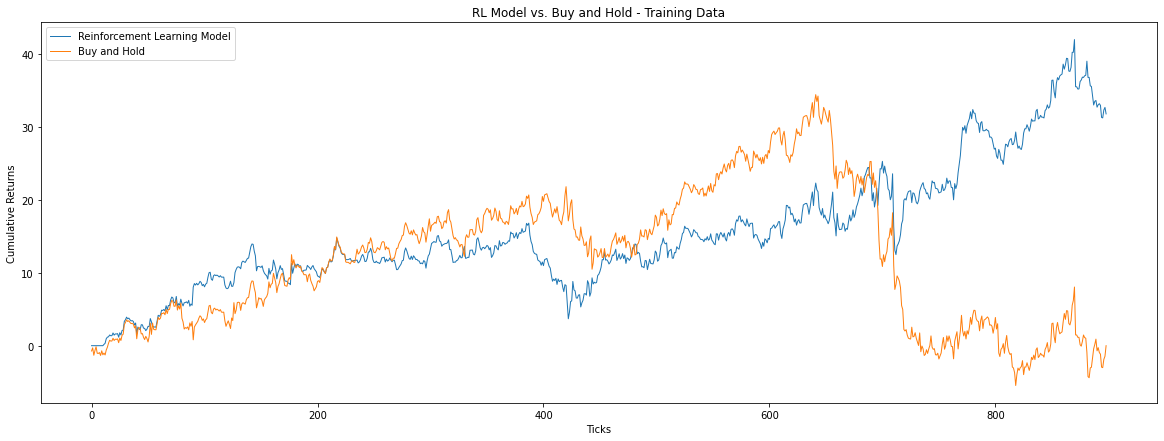

In [126]:
train_returns = returns(positions(x_train, theta), x_train)
plt.figure(figsize=(20,7))
plt.plot((train_returns).cumsum(), label="Reinforcement Learning Model", linewidth=1)
plt.plot(x_train.cumsum(), label="Buy and Hold", linewidth=1)
plt.xlabel('Ticks')
plt.ylabel('Cumulative Returns');
plt.legend()
plt.title("RL Model vs. Buy and Hold - Training Data");

Text(0.5, 1.0, 'RL Model vs. Buy and Hold - Test Data')

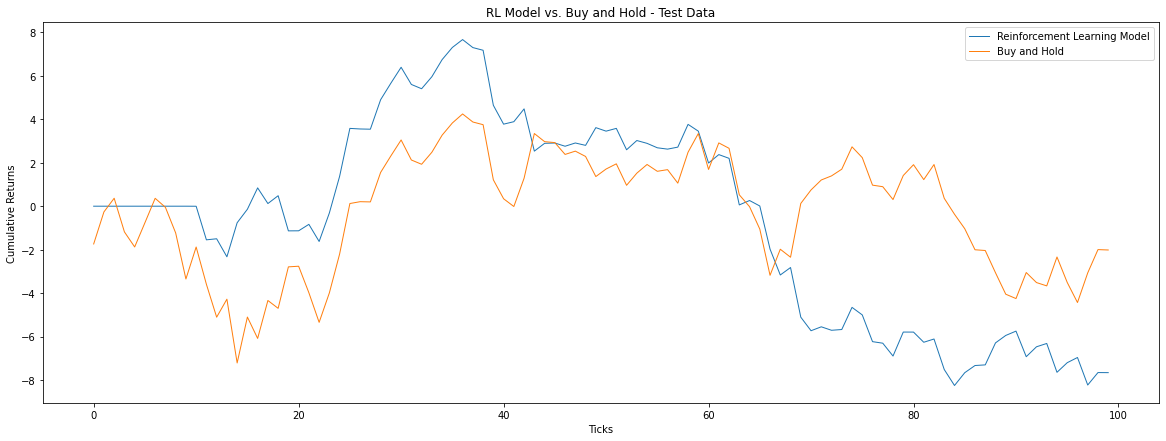

In [127]:
plt.figure(figsize=(20,7))
plt.plot((test_returns).cumsum(), label="Reinforcement Learning Model", linewidth=1)
plt.plot(x_test.cumsum(), label="Buy and Hold", linewidth=1)
plt.xlabel('Ticks')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.title("RL Model vs. Buy and Hold - Test Data")

In [128]:
test_returns.cumsum()[:100]

array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00, -2.24737385e-03, -1.54841667e+00,
       -1.49919640e+00, -2.32913945e+00, -7.62077624e-01, -1.39993709e-01,
        8.43250804e-01,  1.21756440e-01,  4.82160374e-01, -1.13527084e+00,
       -1.13275051e+00, -8.35452236e-01, -1.62378108e+00, -3.09110029e-01,
        1.37693513e+00,  3.58125580e+00,  3.55438985e+00,  3.54403817e+00,
        4.90054582e+00,  5.66159224e+00,  6.39454983e+00,  5.60339743e+00,
        5.40644191e+00,  5.95919557e+00,  6.74529749e+00,  7.30638593e+00,
        7.66911562e+00,  7.30072169e+00,  7.17713248e+00,  4.64452623e+00,
        3.77598508e+00,  3.88910472e+00,  4.47867588e+00,  2.53448449e+00,
        2.89363905e+00,  2.90810371e+00,  2.75984455e+00,  2.90945792e+00,
        2.79950950e+00,  3.61556461e+00,  3.45425266e+00,  3.58177429e+00,
        2.59716483e+00,  

In [133]:
def trading_rrl(df, usd=100):
    cnt = 0
    btc = 0
    percentage_buy = 0.1
    percentage_sell = 0.1
    profit = 0
    
    for index, target in enumerate(test_returns.cumsum()):
        # αν μας τελείωσαν όλα, τελειώνει ο αλγόριθμος
        if usd == 0 and btc == 0:
            return 0,0
        
        if target == 0:
            print(f'{cnt} --------------------------------------------------------------------')
            print(f"Nothing")
            print('-------------------------------------------------------------')
            cnt += 1
            
        # αγοράζουμε
        if target > 0 and usd > 10:
            buy = percentage_buy * usd
            print(buy)
            btc = buy / df['actual_close'][index] + btc
            print(df['actual_close'][index])
            usd = usd - buy
            print(f'{cnt} --------------------------------------------------------------------')
            print(f"You have spent {buy} usd Total: {format(float(btc), 'f')} btc")
            print('-------------------------------------------------------------')
            cnt += 1


        # πουλάμε 
        if target < 0 and btc > 0:
            sell = btc * percentage_sell 
            usd = (sell * df['actual_close'][index]) + usd
            btc = btc - sell
            print(f'{cnt} --------------------------------------------------------------------')           
            print(f"You get: {sell} usd Total: {usd} usd")
            print("--------------------------------------------")
            cnt += 1
    
    print("-------------- END ----------------")
    print(f"USD: {usd}, BTC:{format(float(btc), 'f')} Total -> {usd + df['actual_close'].values[-1] * btc} usd")
    return usd, btc

In [134]:
usd, btc = trading_rrl(result)

0 --------------------------------------------------------------------
Nothing
-------------------------------------------------------------
1 --------------------------------------------------------------------
Nothing
-------------------------------------------------------------
2 --------------------------------------------------------------------
Nothing
-------------------------------------------------------------
3 --------------------------------------------------------------------
Nothing
-------------------------------------------------------------
4 --------------------------------------------------------------------
Nothing
-------------------------------------------------------------
5 --------------------------------------------------------------------
Nothing
-------------------------------------------------------------
6 --------------------------------------------------------------------
Nothing
-------------------------------------------------------------
7 -----------